# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
from scipy.stats import chi2

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
torch.manual_seed(123)

In [2]:
# 한글 깨짐 문제 해결용
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:\Windows\Fonts\H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

# 1. Data

In [3]:
rg3 = pd.read_csv("data/processed/labeled_data_KAMP_rg3_1.csv", parse_dates=True)

In [4]:
rg3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                1256 non-null   int64  
 1   Injection_Time            1256 non-null   float64
 2   Filling_Time              1256 non-null   float64
 3   Plasticizing_Time         1256 non-null   float64
 4   Cycle_Time                1256 non-null   float64
 5   Clamp_Close_Time          1256 non-null   float64
 6   Cushion_Position          1256 non-null   float64
 7   Switch_Over_Position      1256 non-null   float64
 8   Plasticizing_Position     1256 non-null   float64
 9   Max_Injection_Speed       1256 non-null   float64
 10  Max_Screw_RPM             1256 non-null   float64
 11  Average_Screw_RPM         1256 non-null   float64
 12  Max_Injection_Pressure    1256 non-null   float64
 13  Max_Switch_Over_Pressure  1256 non-null   float64
 14  Max_Back

# 2. 학습/평가 데이터 분리를 위한 데이터 전처리

In [5]:
rg3["PassOrFail"].value_counts()

0    1224
1      32
Name: PassOrFail, dtype: int64

In [6]:
# 양품
rg3_Y = rg3[rg3["PassOrFail"] == 0]
print("rg3의 양품 개수:", len(rg3_Y))

rg3의 양품 개수: 1224


In [7]:
# 불량
rg3_N = rg3[rg3["PassOrFail"] == 1]
print("rg3의 불량 개수:", len(rg3_N))

rg3의 불량 개수: 32


**잡음 제거 오토인코더 모델에 학습시킬 데이터의 형태는 클래스 변수가 없어야 하므로 변수 "PassOrFail"을 제거함

In [8]:
# 양품
rg3_Y = rg3_Y.drop(columns=["PassOrFail"], axis=1)
# 불량
rg3_N = rg3_N.drop(columns=["PassOrFail"], axis=1)

In [9]:
# MinMaxscaler를 통한 데이터 정규화

scaler = MinMaxScaler()

rg3_Y = scaler.fit_transform(rg3_Y)
rg3_N = scaler.fit_transform(rg3_N)

#### 학습/평가 데이터 분리 (6:4 비율)

In [10]:
rg3_Y.shape

(1224, 24)

In [11]:
# 학습 데이터 (양품)
rg3_train_Y = rg3_Y[:754]

# 평가 데이터 (양품)
rg3_test_Y = rg3_Y[754:]

# 평가 데이터 (불량)
rg3_test_N = rg3_N

print(f"rg3 학습 데이터 (양품) 개수: {len(rg3_train_Y)}")
print(f"rg3 평가 데이터 (양품) 개수: {len(rg3_test_Y)}")
print(f"rg3 평가 데이터 (불량) 개수: {len(rg3_test_N)}")

rg3 학습 데이터 (양품) 개수: 754
rg3 평가 데이터 (양품) 개수: 470
rg3 평가 데이터 (불량) 개수: 32


# 3. Autoencoder 모델링

In [12]:
rg3_train_Y.shape

(754, 24)

In [13]:
# Autoencoder Class

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.enc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(rg3_train_Y.shape[1], 15),
            nn.ReLU(),
            nn.Linear(15, 5),
            nn.ReLU(),
        )
        
        self.dec = nn.Sequential(
            nn.Linear(5, 15),
            nn.ReLU(),
            nn.Linear(15, rg3_train_Y.shape[1]),
            nn.ReLU(),
        )
        
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [14]:
# Training Parameters

batch_size = 30
lr = 0.01   # learning rate
w_d = 1e-4  # weight decay
# momentum = 0.9  <- This is for SGD
epochs = 30

In [15]:
# Loader Preparation

class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset[idx]
        # row = self.dataset.iloc[idx]
        data = torch.from_numpy(row).float()
        return data
    
    
class rg3DataLoader(Loader):
    def __init__(self, data_for_ae):
        super(rg3DataLoader, self).__init__()
        self.dataset = data_for_ae

In [16]:
# train/validation sets split

rg3_train_Y_t, rg3_train_Y_v = train_test_split(
    rg3_train_Y, test_size=0.2, random_state=123
)

In [17]:
train_set = rg3DataLoader(rg3_train_Y_t)

train_ = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [18]:
valid_set = rg3DataLoader(rg3_train_Y_v)

valid_ = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [19]:
metrics = defaultdict(list)
device = 'cpu'       #'cuda' if torch.cuda.is_available() else 'cpu'
model = AE()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=w_d
)

In [20]:
summary(model, (24, ), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5]                   --
|    └─Dropout: 2-1                      [-1, 24]                  --
|    └─Linear: 2-2                       [-1, 15]                  375
|    └─ReLU: 2-3                         [-1, 15]                  --
|    └─Linear: 2-4                       [-1, 5]                   80
|    └─ReLU: 2-5                         [-1, 5]                   --
├─Sequential: 1-2                        [-1, 24]                  --
|    └─Linear: 2-6                       [-1, 15]                  90
|    └─ReLU: 2-7                         [-1, 15]                  --
|    └─Linear: 2-8                       [-1, 24]                  384
|    └─ReLU: 2-9                         [-1, 24]                  --
Total params: 929
Trainable params: 929
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

In [21]:
# AE Training

model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    
    # Training
    running_loss_t = 0.0

    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
    train_loss = running_loss_t/len(train_set)
    metrics['train_loss'].append(train_loss)
    
    # Validation
    model.eval()
    running_loss_v = 0.0
    with torch.no_grad():
        for bx, (data) in enumerate(valid_):
            sample = model(data.to(device))
            loss = criterion(data.to(device), sample)
            accuracy = torch.sum(torch.isclose(data.to(device), sample, rtol=0.1))
            running_loss_v += loss.item()
    valid_loss = running_loss_v/len(valid_set)
    metrics['valid_loss'].append(valid_loss)
    
    model.train()
    
    ep_end = time.time()
    if (epoch+1) % 5 == 0:
        print('-----------------------------------------------')
        print('[EPOCH] {}/{}\n[TRAIN LOSS] {}    [VALID LOSS] {}'.format(epoch+1, epochs, train_loss, valid_loss))
        print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 5/30
[TRAIN LOSS] 0.0007980760977685352    [VALID LOSS] 0.0006160649736196
Epoch Complete in 0:00:00.029000
-----------------------------------------------
[EPOCH] 10/30
[TRAIN LOSS] 0.0007289670203900456    [VALID LOSS] 0.000556725761945674
Epoch Complete in 0:00:00.030970
-----------------------------------------------
[EPOCH] 15/30
[TRAIN LOSS] 0.0007149609142472693    [VALID LOSS] 0.0005445497677914354
Epoch Complete in 0:00:00.028001
-----------------------------------------------
[EPOCH] 20/30
[TRAIN LOSS] 0.0006942640817036874    [VALID LOSS] 0.0005384555135835086
Epoch Complete in 0:00:00.028000
-----------------------------------------------
[EPOCH] 25/30
[TRAIN LOSS] 0.0006732771861958464    [VALID LOSS] 0.0005193966323670172
Epoch Complete in 0:00:00.029006
-----------------------------------------------
[EPOCH] 30/30
[TRAIN LOSS] 0.0006716025106695358    [VALID LOSS] 0.0004955360554898811
Epoch Complete in 0:00:00.0280

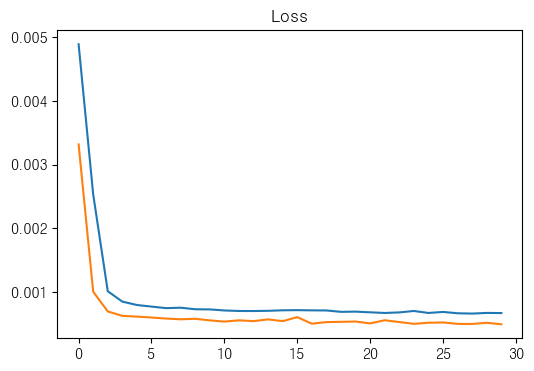

In [22]:
# Loss

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])
ax.plot(metrics['valid_loss'])
plt.show();

# 4. Mahalanobis Distance를 사용한 임계값 정의

In [23]:
# 학습 데이터의 예측값

rg3_train_pred = model(torch.tensor(rg3_train_Y).float())

In [24]:
rg3_train_pred

tensor([[0.3353, 0.0000, 0.4503,  ..., 0.7713, 0.2252, 0.1853],
        [0.3361, 0.0000, 0.4588,  ..., 0.7515, 0.1640, 0.1396],
        [0.3284, 0.0394, 0.3911,  ..., 0.7620, 0.4162, 0.3618],
        ...,
        [0.3345, 0.2435, 0.3177,  ..., 0.5829, 0.5233, 0.5178],
        [0.3299, 0.1791, 0.3390,  ..., 0.6169, 0.5053, 0.4925],
        [0.3335, 0.1886, 0.3411,  ..., 0.6273, 0.4784, 0.4627]],
       grad_fn=<ReluBackward0>)

In [25]:
# 학습 데이터의 복원 오차 (예측값 - 실제값)

rg3_train_Y_loss = rg3_train_pred.detach().numpy() - rg3_train_Y

In [26]:
rg3_train_Y_loss.shape

(754, 24)

In [27]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [28]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

In [29]:
clf = MahalanobisOneclassClassifier(rg3_train_Y_loss, significance_level=0.01)

Critical value is:  41.638398118858476


In [30]:
threshold = clf.critical_value

# 5. 데이터 각각의 예측값과 복원 오차 확인

## 5.1. 평가 데이터 (양품) 대상 모델 성능 검증 

In [31]:
# 예측값
rg3_predict_Y = model(torch.tensor(rg3_test_Y).float())

In [32]:
rg3_predict_Y.shape

torch.Size([470, 24])

In [33]:
# 양품 평가 데이터의 복원 오차 (예측값 - 실제값)

rg3_test_Y_loss = rg3_predict_Y.detach().numpy() - rg3_test_Y

In [34]:
rg3_test_Y_loss.shape

(470, 24)

In [35]:
# 예측값
rg3_test_MD_Y = clf.predict_proba(rg3_test_Y_loss)

In [36]:
rg3_test_MD_Y.shape

(470,)

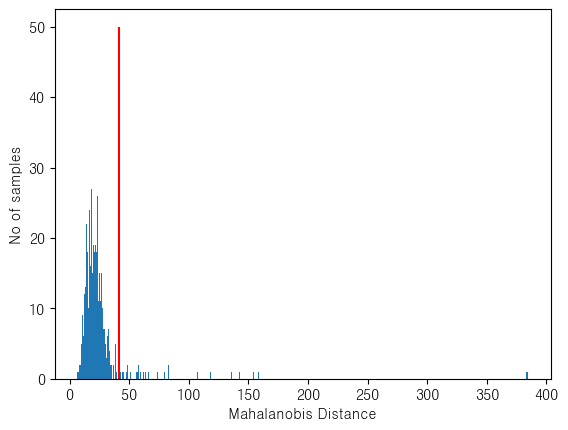

In [37]:
# 시각화

plt.hist(rg3_test_MD_Y, bins=500)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 50, color="red")
plt.show();

In [38]:
# 불량으로 판단한 데이터 확인

rg3_test_Y_anomalies = rg3_test_MD_Y > threshold
print("불량 개수: ", np.sum(rg3_test_Y_anomalies))
print("정확도: ", (rg3_test_Y.shape[0]-np.sum(rg3_test_Y_anomalies))/rg3_test_Y.shape[0])

불량 개수:  31
정확도:  0.9340425531914893


## 5.2. 평가 데이터 (불량) 대상 모델 성능 검증 

In [39]:
# 예측값
rg3_predict_MD_N = model(torch.tensor(rg3_test_N).float())

In [40]:
rg3_predict_MD_N.shape

torch.Size([32, 24])

In [41]:
# 불량 평가 데이터의 복원 오차 (예측값 - 실제값)

rg3_test_N_loss = rg3_predict_MD_N.detach().numpy() - rg3_test_N

In [42]:
rg3_test_N_loss.shape

(32, 24)

In [43]:
# 예측값
rg3_test_MD_N = clf.predict_proba(rg3_test_N_loss)

In [44]:
rg3_test_MD_N

array([ 145.99699175,  167.64655814,  229.35835141,  178.67785905,
        131.90058912, 1395.63669095,  917.20596448, 1458.73095083,
       1324.67231146, 1691.03974466, 1148.14460452, 1130.20559209,
       1244.03183754, 1221.38442761, 1378.90313185, 1422.55371523,
        956.15078906, 1107.60319874,  931.47459725, 1004.65346839,
        858.66748113,  997.59777834,  855.81332705,  945.64399189,
       1068.32867282,  690.14435471, 1019.5832735 , 1024.00903427,
       1118.48874007,  696.48012302,  354.02983533,  205.9748895 ])

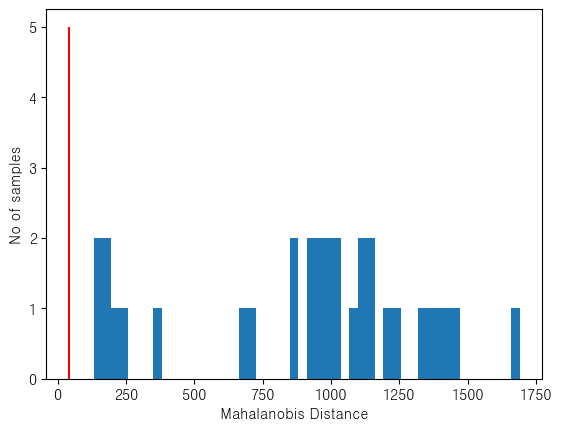

In [45]:
# 시각화

plt.hist(rg3_test_MD_N, bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 5, color="red")
plt.show();

In [46]:
# 불량으로 판단한 데이터 확인

rg3_test_N_anomalies = rg3_test_MD_N > threshold
print("불량 개수: ", np.sum(rg3_test_N_anomalies))
print("정확도: ", np.sum(rg3_test_N_anomalies)/rg3_test_N.shape[0])

불량 개수:  32
정확도:  1.0


# 6. 결과 분석

In [47]:
# 평가 데이터의 실제값

rg3_true = np.concatenate(
    [np.zeros(len(rg3_test_Y_anomalies)), np.ones(len(rg3_test_N_anomalies))]
)

In [48]:
rg3_true.shape

(502,)

In [49]:
# 평가 데이터의 예측값

rg3_prediction = np.concatenate(
    [rg3_test_Y_anomalies, rg3_test_N_anomalies]
)

In [50]:
rg3_prediction.shape

(502,)

In [51]:
confusion_matrix(rg3_true, rg3_prediction)

array([[439,  31],
       [  0,  32]], dtype=int64)

In [52]:
print(classification_report(rg3_true, rg3_prediction))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97       470
         1.0       0.51      1.00      0.67        32

    accuracy                           0.94       502
   macro avg       0.75      0.97      0.82       502
weighted avg       0.97      0.94      0.95       502

